# Определение токсичных комментариев

**Описание проекта:** Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. В распоряжении набор данных с разметкой о токсичности правок.

**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Задача:** Постройте модель со значением метрики качества F1 на тестовой выборке не меньше 0.75.

### План проекта

<br>[1. Загрузка и подготовка данных](#step1)
<br>[1.1 Вывод к этапу 1](#step2)
<br>[2. Обучение моделей](#step3)
<br>[3.Выводы](#step4)

# 1. Загрузка и подготовка данных<a id='step1'></a>

In [1]:
#Прежде всего импортирую нужные на этом этапе библиотеки
import pandas as pd #Импортирую библиотеку pandas
import numpy as np #Импортирую библиотеку высокоуровневых математических функций numpy
import nltk #Импортирую библиотеку для обработки текстов NLTK
from nltk.stem import WordNetLemmatizer #Из библиотеки NLTK импортирую функциию для лемматизации WordNetLemmatizer
from nltk.corpus import stopwords #Из библиотеки NLTK импортирую функциию stopwords для определения стоп-слов
from sklearn.feature_extraction.text import TfidfVectorizer #Из библиотеки sklearn импортирую функциию TfidfVectorizer
import re #Импортирую модуль re
%matplotlib inline
import matplotlib.pyplot as plt #Импортирую библиотеку matplotlib
import seaborn as sns #Импортирую библиотеку seaborn
from sklearn.model_selection import train_test_split #Импортирую функцию train_test_split из библиотеки sklearn
import catboost as cb #Импортирую CatBoost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV #Импортирую функцию GridSearchCV

In [2]:
#Загружаю данные
try: 
    df = pd.read_csv('/datasets/toxic_comments.csv')
except: 
    df = pd.read_csv('C:/Users/Les/Dropbox/DS/data/toxic_comments.csv')

In [3]:
#Получаю информацию по датасету
display(df.head(10))
df.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
#Объявляю корпус текстов, перевожу его в тип юникод
corpus = df['text'].values.astype('U')
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [5]:
#Объявляю лемматизатор
wnl = WordNetLemmatizer()

In [6]:
#Объявляю функцию для очистки и лемматизации текстов clear_text(text)
def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
    return " ".join(lemm)

In [7]:
#В цикле применяю функцию для очистки и лемматизации текстов clear_text(text)
for i in range(len(corpus)):
    corpus[i] = clear_text(corpus[i])

In [8]:
#Объединяю датасет и корпус
df['lemm_text'] = corpus
display(df.head(10))
df.info()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me a well use the tool we...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense wa offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159571 non-null  object
 1   toxic      159571 non-null  int64 
 2   lemm_text  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


0    143346
1     16225
Name: toxic, dtype: int64


<AxesSubplot:xlabel='toxic', ylabel='count'>

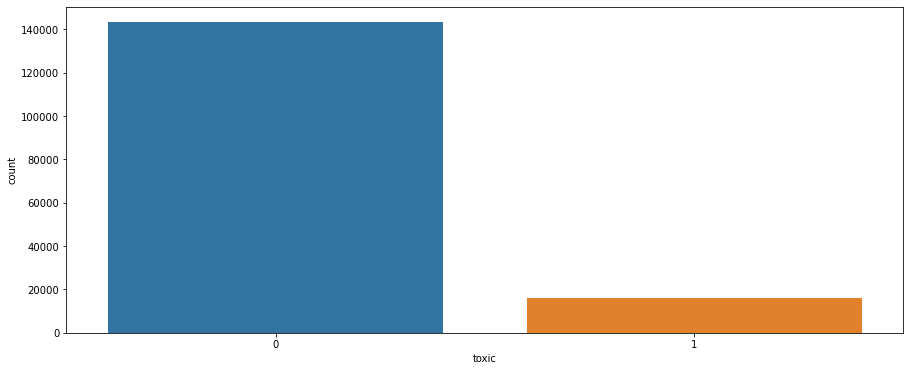

In [9]:
#Определяю количество объектов мажорного и минорного классов
print(df['toxic'].value_counts())
zeroes = df['toxic'].value_counts()[0]
ones = df['toxic'].value_counts()[1]

#Для наглядности строю график
plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=df)

In [10]:
#Определяю признаки и целевой признак
features = df['lemm_text']
target = df['toxic']

#Разделяю датасет на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

In [11]:
#nltk.download('stopwords')
#Объявляю набор стоп-слов 
stopwords = set(stopwords.words('english'))
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
#Выполняю векторизацию текстов
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

In [12]:
#Оцениваю результаты
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(119678, 139462)
(39893, 139462)
(119678,)
(39893,)


## 1.1 Вывод к этапу 1 <a id='step2'></a>

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.
<br>Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк.

<br>**Исходный датасет состоит из следующих столбцов:**
<br>• text — текст комментария;
<br>• toxic — является ли комментарий токсичным (1) или нет (0)
<br>Пропуски в данных отсутствуют.

<br>После открытия датасета и ознакомления с общей информацией объявлен корпус текстов и переведен в тип юникод. Затем тексты были очищены и лемматизированы.
<br>Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета. Следовательно этот аспект необходимо будет учесть в дальнейшем при обучении моделей.
<br>Для векторизации текстов был использован TfidfVectorizer(). После векторизации датасет  образовал матрицу размером 159571 строк на 164272 столбцов.

<br>В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1.

Можно приступать к обучению моделей.

# 2. Обучение моделей<a id='step3'></a>

В качестве моделей будем использовать Логистическую регрессию, Случайный лес и Катбуст классификатор.

In [13]:
%%time
#Обучаю и проверяю Логистическую регрессию на кросс-валидации, указываю параметр class_weight = 'balanced'
regression = LogisticRegression(fit_intercept=True, 
                                class_weight = 'balanced', 
                                random_state=42,
                                solver='liblinear'
                               )
#Определяю словарь с набором параметров
regression_parametrs = {'C': [0.01, 0.1, 1, 10, 100]}

#Применяю GridSearchCV с кросс-валидацией
regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train, target_train)

regression.fit(features_train, target_train)
regression_cv_score = cross_val_score(regression,features_train, target_train,scoring='f1',cv=3).mean()
print('Среднее качество модели Логистической регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели Логистической регрессии на кросс-валидации: 0.7442312210849932
Wall time: 39.8 s


In [14]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
regression_params = regression_grid.best_params_
regression_score = regression_grid.score(features_train, target_train)
print(regression_params)
print(regression_score)
print('_______________')

{'C': 10}
0.9161026881923703
_______________
Wall time: 61 ms


In [15]:
%%time
#Проверяю Логистическую регрессию на тестовой выборке
regression_model = LogisticRegression(fit_intercept=True,
                                class_weight = 'balanced',
                                random_state=42,
                                solver='liblinear',
                                C=regression_params['C']
                               )

regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

Wall time: 3.25 s


In [16]:
#Определяю метрику f1
regression_predictions = regression_model.predict(features_test)
regression_f1 = round(f1_score(target_test, regression_predictions), 3) 
print(regression_f1)

0.763


In [17]:
%%time
#Подбираю оптимальные гиперпараметры для Случайного леса на кросс-валидации, указываю параметр class_weight = 'balanced'
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1 )
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(20, 45, 5),
                     'max_depth': range(1, 8, 2),
                     'min_samples_leaf': range(1,6),
                     'min_samples_split': range(2,6,2)}

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='f1', cv=3)
forest_grid.fit(features_train, target_train)

Wall time: 14min 34s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              r

In [18]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
0.307563617152417
_______________
Wall time: 500 ms


In [19]:
%%time
#Обучаю модель Случайного леса на оптимальных гиперпараметрах
forest_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced',
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику f1
forest_predictions = forest_model.predict(features_test)
forest_f1 =  round(f1_score(target_test, forest_predictions), 3)
print(forest_f1)

0.316
Wall time: 968 ms


In [20]:
%%time
import catboost as cb #Импортирую CatBoost

#Объявляю модель с учетом дисбаланса классов
cb = cb.CatBoostClassifier(class_weights=[1, zeroes/ones])
#Определяю словарь с набором параметров
cb_parametrs = {'depth': [2, 4, 6, 8]}

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring='f1', cv=3)
cb_grid.fit(features_train, target_train)

Learning rate set to 0.066843
0:	learn: 0.6723477	total: 483ms	remaining: 8m 2s
1:	learn: 0.6591229	total: 749ms	remaining: 6m 13s
2:	learn: 0.6485233	total: 1.03s	remaining: 5m 43s
3:	learn: 0.6399131	total: 1.33s	remaining: 5m 30s
4:	learn: 0.6325409	total: 1.59s	remaining: 5m 16s
5:	learn: 0.6282737	total: 1.88s	remaining: 5m 11s
6:	learn: 0.6231210	total: 2.18s	remaining: 5m 9s
7:	learn: 0.6191956	total: 2.45s	remaining: 5m 3s
8:	learn: 0.6122594	total: 2.72s	remaining: 4m 59s
9:	learn: 0.6085526	total: 2.98s	remaining: 4m 55s
10:	learn: 0.6052040	total: 3.26s	remaining: 4m 52s
11:	learn: 0.6009879	total: 3.52s	remaining: 4m 50s
12:	learn: 0.5987957	total: 3.79s	remaining: 4m 47s
13:	learn: 0.5968406	total: 4.05s	remaining: 4m 45s
14:	learn: 0.5931050	total: 4.33s	remaining: 4m 44s
15:	learn: 0.5878545	total: 4.58s	remaining: 4m 41s
16:	learn: 0.5850685	total: 4.86s	remaining: 4m 40s
17:	learn: 0.5830604	total: 5.12s	remaining: 4m 39s
18:	learn: 0.5813504	total: 5.38s	remaining: 4m

GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000257DBE3C4C8>,
             iid='deprecated', n_jobs=None, param_grid={'depth': [2, 4, 6, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [21]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 8}
0.847981172317423
_______________
Wall time: 18.7 s
Parser   : 284 ms


In [22]:
%%time
import catboost as cb #Импортирую CatBoost (почему-то без повторного импортирования ячейка не работала)
#Обучаю модель на оптимальных гиперпараметрах
cb_model = cb.CatBoostClassifier(class_weights=[1, zeroes/ones], depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=10)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику f1
cb_f1 = round(f1_score(target_test, cb_model_predictions), 3)
print(cb_f1)

Learning rate set to 0.079478
0:	learn: 0.6524294	total: 12.1s	remaining: 3h 22m 16s
10:	learn: 0.5201349	total: 1m	remaining: 1h 29m 55s
20:	learn: 0.4760022	total: 1m 41s	remaining: 1h 18m 37s
30:	learn: 0.4471430	total: 2m 22s	remaining: 1h 14m 19s
40:	learn: 0.4282421	total: 3m 4s	remaining: 1h 11m 50s
50:	learn: 0.4126324	total: 3m 45s	remaining: 1h 9m 51s
60:	learn: 0.4000932	total: 4m 26s	remaining: 1h 8m 29s
70:	learn: 0.3895116	total: 5m 8s	remaining: 1h 7m 16s
80:	learn: 0.3805586	total: 5m 49s	remaining: 1h 6m 9s
90:	learn: 0.3722465	total: 6m 35s	remaining: 1h 5m 50s
100:	learn: 0.3651094	total: 7m 19s	remaining: 1h 5m 8s
110:	learn: 0.3586134	total: 8m 1s	remaining: 1h 4m 18s
120:	learn: 0.3534511	total: 8m 45s	remaining: 1h 3m 36s
130:	learn: 0.3477060	total: 9m 29s	remaining: 1h 2m 59s
140:	learn: 0.3426507	total: 10m 22s	remaining: 1h 3m 10s
150:	learn: 0.3371949	total: 11m 22s	remaining: 1h 3m 56s
160:	learn: 0.3303552	total: 12m 5s	remaining: 1h 2m 59s
170:	learn: 0.3

Проверка моделей на адекватность.
<br>Для надлежащей проверки моделей на адекватность, данные константной модели будут набором единиц. 

In [23]:
const_model = [1 for i in range(len(target_test))]
const_f1 = f1_score(target_test.reset_index(drop=True), const_model)
print(const_f1)

0.18457757855696372


In [24]:
#Создаю итоговую таблицу
columns = ['Модель', 'Время работы модели, сек.', 'f1-мера']
const_model = ['Константная модель', 0, const_f1]
regression_model = ['Логистическая регрессия', 5.63, regression_f1]
forest_model = ['Случайный лес', 4.7, forest_f1]
cd_model = ['CatBoostRegressor', 4553.0, cb_f1]

table = pd.DataFrame([const_model, regression_model, forest_model, cd_model], columns = columns)
table['Качество по отношению к константной модели, %'] = round((table['f1-мера']/const_f1) * 100, 2)

display(table)

,Модель,"Время работы модели, сек.",f1-мера,"Качество по отношению к константной модели, %"
0,Константная модель,0.00,0.184578,100.00
1,Логистическая регрессия,5.63,0.763000,413.38
2,Случайный лес,4.70,0.316000,171.20
3,CatBoostRegressor,4553.00,0.762000,412.83


# 3. Выводы<a id='step4'></a>

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.
<br>Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк.
<br>Затем тексты комментариев были очищены и лемматизированы.
<br>Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета.
<br>После векторизации датасет  образовал матрицу размером 159571 строк на 164272 столбцов. В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1.

<br>В качестве моделей использованы Логистическая регрессия, Случайный лес и Катбуст классификатор.
<br>По результатам подбора гиперпараметров и обучения моделей наилучший результат показал Катбуст классификатор, наихудший - Случайный лес. Все выбранные модели прошли проверку на адекватность в сравнении с константной моделью. Результаты сведены в таблицу. Стоит отметить, что Катбуст классификатор выполнял расчеты значительно дольше, нежели Логистическая регрессия, полученное при этом значение метрики f1 всего лишь на 0,2% лучше, чем у Логистической регрессии.

В связи с этим модели Логистическая регрессия и Катбуст классификатор подходят для решения поставленной задачи. Однако, для экономии времени и вычислителной мощности Логистическая регрессия является оптимальным решением для данной задачи.